In [1]:
# --- 1. Reikalingos bibliotekos ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import pickle
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"TensorFlow versija: {tf.__version__}")
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow versija: 2.19.0


In [2]:
# --- 2. Duomenų gavimas iš Binance API (jei reikia) arba naudojami jau išsaugoti ---
cached_data_path = os.path.join('..', '..', 'data', 'btc_data_1y_15m.csv')

if os.path.exists(cached_data_path):
    print(f"Naudojami cached duomenys iš {cached_data_path}")
    df = pd.read_csv(cached_data_path)
    df['time'] = pd.to_datetime(df['time'])
    print(f"Duomenų dydis: {df.shape}")
    print(df.head())
else:
    print(f"KLAIDA: Nerastas duomenų failas {cached_data_path}")
    print("Pirma paleiskite duomenų gavimo skriptą arba kitą modelio failą, pvz., lstm_model.ipynb")

Naudojami cached duomenys iš ..\..\data\btc_data_1y_15m.csv
Duomenų dydis: (35040, 12)
                 time      open      high       low     close     volume  \
0 2024-05-21 14:00:00  70595.92  70847.77  70560.00  70777.91  584.15346   
1 2024-05-21 14:15:00  70777.91  70833.80  70329.82  70419.44  705.06014   
2 2024-05-21 14:30:00  70419.44  70927.48  70417.79  70456.81  611.94862   
3 2024-05-21 14:45:00  70456.82  70507.24  70187.76  70213.20  756.49794   
4 2024-05-21 15:00:00  70213.21  70342.68  70153.69  70247.83  669.15517   

      close_time  quote_asset_volume  number_of_trades  \
0  1716300899999        4.130733e+07             23464   
1  1716301799999        4.976077e+07             26447   
2  1716302699999        4.323031e+07             28584   
3  1716303599999        5.323694e+07             50211   
4  1716304499999        4.699733e+07             34871   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                    307.29840      

In [3]:
# --- 3. Duomenų paruošimas ir normalizavimas ---
df = df.sort_values('time')
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']
scaler = MinMaxScaler()
df_original = df.copy()
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Patikriname normalizuotus duomenis
print("Normalizuotų duomenų statistika:")
print(df_normalized[columns_to_normalize].describe())

# Išsaugome scaler'į vėlesniam naudojimui
import pickle
os.makedirs('../../models', exist_ok=True)
with open('../../models/cnn_lstm_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Normalizuotų duomenų statistika:
               open          high           low         close        volume
count  35040.000000  35040.000000  35040.000000  35040.000000  35040.000000
mean       0.504274      0.496868      0.514773      0.504292      0.031584
std        0.274743      0.274887      0.274528      0.274753      0.040543
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.242512      0.234315      0.253421      0.242504      0.010924
50%        0.547065      0.540466      0.556620      0.547083      0.019525
75%        0.777161      0.769569      0.787709      0.777164      0.036745
max        1.000000      1.000000      1.000000      1.000000      1.000000


In [4]:
# --- 4. Sliding window sekų kūrimas ---
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    feature_columns = ['open', 'high', 'low', 'close', 'volume']
    data_array = data[feature_columns].values
    target_idx = feature_columns.index(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    return np.array(X), np.array(y)

sequence_length = 48  # Hibridiniam modeliui pasirenkame vidutinio ilgio seką
target_column = 'close'
feature_columns = ['open', 'high', 'low', 'close', 'volume']
X, y = create_sequences(df_normalized, target_column, sequence_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (34992, 48, 5), y shape: (34992,)


In [5]:
# --- 5. Duomenų padalijimas į mokymo ir testavimo rinkinius ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (27993, 48, 5), X_test shape: (6999, 48, 5)
y_train shape: (27993,), y_test shape: (6999,)


In [6]:
# --- 6. CNN-LSTM hibridinio modelio sukūrimas ---
def create_cnn_lstm_model(input_shape):
    model = models.Sequential([
        # 1D konvoliucijos sluoksnis lokalių šablonų aptikimui
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.BatchNormalization(),
        
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.BatchNormalization(),
        
        # LSTM sluoksniai laiko eilučių priklausomybių modeliavimui
        layers.LSTM(units=100, return_sequences=True),
        layers.Dropout(0.2),
        
        layers.LSTM(units=50),
        layers.Dropout(0.2),
        
        # Tankinimo sluoksniai
        layers.Dense(50, activation='relu'),
        layers.Dense(25, activation='relu'),
        layers.Dense(1)  # Išvesties sluoksnis (kainų prognozė)
    ])
    return model

# Sukuriame modelį
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, features)
cnn_lstm_model = create_cnn_lstm_model(input_shape)

# Sukompiliuojame modelį
cnn_lstm_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

cnn_lstm_model.summary()

d:\CA_BTC\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 100)        │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,147 (594.32 KB)

 Trainable params: 151,763 (592.82 KB)

 Non-trainable params: 384 (1.50 KB)

In [7]:
# --- 7. Modelio apmokymas ---
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
checkpoint = callbacks.ModelCheckpoint(
    filepath='../../models/cnn_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Apmokymo paleidimas
print("Pradedamas modelio apmokymas...")
history = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("Modelio apmokymas baigtas.")

# Išsaugome modelį
cnn_lstm_model.save('../../models/cnn_lstm_model.h5')
print("Modelis išsaugotas į: ../../models/cnn_lstm_model.h5")

Pradedamas modelio apmokymas...
Epoch 1/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079 - mae: 0.0561
Epoch 1: val_loss improved from inf to 0.00793, saving model to ../../models/cnn_lstm_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0079 - mae: 0.0561 - val_loss: 0.0079 - val_mae: 0.0811 - learning_rate: 0.0010
Epoch 2/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - mae: 0.0266
Epoch 2: val_loss improved from 0.00793 to 0.00442, saving model to ../../models/cnn_lstm_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 0.0044 - val_mae: 0.0542 - learning_rate: 0.0010
Epoch 3/100
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.6986e-04 - mae: 0.0220
Epoch 3: val_loss did not improve from 0.00442
875/875 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 8.6978e-04 - mae: 0.0220 - val_loss: 0.0098 - val_mae: 0.0806 - learning_rate: 0.0010
Epoch 4/100
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.4118e-04 - mae: 0.0202
Epoch 4: val_loss did not improve from 0.00442
875/875 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 7.4109e-04 - mae: 0.0202 - val_loss: 0.0045 - val_mae: 0.0534 - learning_rate: 0.0010
Epoch 5/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0874e-04 - mae: 0.0183
Epoch 5: val_loss did not improve from 0.00442
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 6.0873e-04 - mae: 0.0183 - val_loss: 0.0077 - val_mae: 0.0719 - learning_rate: 0.0010
Epoch 6/100
872/875 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 4.0835e-04 - mae: 0.0150 - val_loss: 0.0026 - val_mae: 0.0382 - learning_rate: 5.0000e-04
Epoch 9/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.8606e-04 - mae: 0.0146
Epoch 9: val_loss did not improve from 0.00263
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.8604e-04 - mae: 0.0146 - val_loss: 0.0034 - val_mae: 0.0464 - learning_rate: 5.0000e-04
Epoch 10/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.6837e-04 - mae: 0.0141
Epoch 10: val_loss did not improve from 0.00263
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.6836e-04 - mae: 0.0141 - val_loss: 0.0066 - val_mae: 0.0741 - learning_rate: 5.0000e-04
Epoch 11/100
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.5255e-04 - mae: 0.0139
Epoch 11: val_loss did not improve from 0.00263
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 3.5256e-04 - mae: 0.0139 - val_loss: 0.0050 - val_mae: 0.0593 - learning_rate: 5.0000e-04
Epoch 12/100
874/875 ━━━━━━━━━

875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 2.3176e-04 - mae: 0.0112 - val_loss: 0.0023 - val_mae: 0.0356 - learning_rate: 2.5000e-04
Epoch 15/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0469e-04 - mae: 0.0106
Epoch 15: val_loss did not improve from 0.00227
875/875 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 2.0468e-04 - mae: 0.0106 - val_loss: 0.0025 - val_mae: 0.0373 - learning_rate: 2.5000e-04
Epoch 16/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8181e-04 - mae: 0.0099
Epoch 16: val_loss did not improve from 0.00227
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1.8181e-04 - mae: 0.0099 - val_loss: 0.0031 - val_mae: 0.0456 - learning_rate: 2.5000e-04
Epoch 17/100
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5780e-04 - mae: 0.0093
Epoch 17: val_loss improved from 0.00227 to 0.00184, saving model to ../../models/cnn_lstm_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1.5779e-04 - mae: 0.0093 - val_loss: 0.0018 - val_mae: 0.0309 - learning_rate: 2.5000e-04
Epoch 18/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4635e-04 - mae: 0.0089
Epoch 18: val_loss improved from 0.00184 to 0.00161, saving model to ../../models/cnn_lstm_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1.4634e-04 - mae: 0.0089 - val_loss: 0.0016 - val_mae: 0.0290 - learning_rate: 2.5000e-04
Epoch 19/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3599e-04 - mae: 0.0086
Epoch 19: val_loss improved from 0.00161 to 0.00155, saving model to ../../models/cnn_lstm_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1.3598e-04 - mae: 0.0086 - val_loss: 0.0015 - val_mae: 0.0292 - learning_rate: 2.5000e-04
Epoch 20/100
872/875 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3025e-04 - mae: 0.0084
Epoch 20: val_loss did not improve from 0.00155
875/875 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 1.3022e-04 - mae: 0.0084 - val_loss: 0.0019 - val_mae: 0.0324 - learning_rate: 2.5000e-04
Epoch 21/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1942e-04 - mae: 0.0081
Epoch 21: val_loss did not improve from 0.00155
875/875 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 1.1941e-04 - mae: 0.0081 - val_loss: 0.0017 - val_mae: 0.0314 - learning_rate: 2.5000e-04
Epoch 22/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1432e-04 - mae: 0.0079
Epoch 22: val_loss did not improve from 0.00155
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1.1432e-04 - mae: 0.0079 - val_loss: 0.0021 - val_mae: 0.0344 - learning_rate: 2.5000e-04
Epoch 23/100
872/875 ━━━━━━━

875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 9.3665e-05 - mae: 0.0070 - val_loss: 0.0015 - val_mae: 0.0281 - learning_rate: 1.2500e-04
Epoch 27/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.8920e-05 - mae: 0.0069
Epoch 27: val_loss did not improve from 0.00147
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 8.8915e-05 - mae: 0.0069 - val_loss: 0.0016 - val_mae: 0.0290 - learning_rate: 1.2500e-04
Epoch 28/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.7515e-05 - mae: 0.0068
Epoch 28: val_loss did not improve from 0.00147
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 8.7512e-05 - mae: 0.0068 - val_loss: 0.0018 - val_mae: 0.0307 - learning_rate: 1.2500e-04
Epoch 29/100
872/875 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.6061e-05 - mae: 0.0067
Epoch 29: val_loss did not improve from 0.00147
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 8.6057e-05 - mae: 0.0067 - val_loss: 0.0016 - val_mae: 0.0291 - learning_rate: 1.2500e-04
Epoch 30/100
874/875 ━━━━━━━

Modelio apmokymas baigtas.
Modelis išsaugotas į: ../../models/cnn_lstm_model.h5


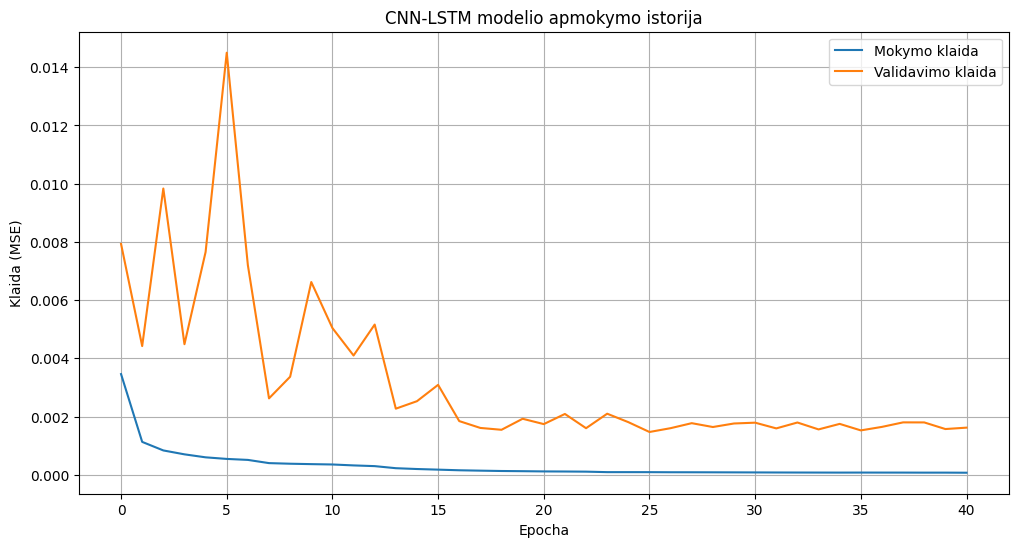

In [8]:
# --- 8. Apmokymo istorijos vizualizacija ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Mokymo klaida')
plt.plot(history.history['val_loss'], label='Validavimo klaida')
plt.title('CNN-LSTM modelio apmokymo istorija')
plt.xlabel('Epocha')
plt.ylabel('Klaida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

if 'lr' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Kitimas')
    plt.xlabel('Epocha')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

In [9]:
# --- 9. Modelio testavimas ---
y_pred = cnn_lstm_model.predict(X_test)

def inverse_transform_predictions(predictions, scaler, target_idx=3, feature_names=None):
    dummy = np.zeros((len(predictions), len(feature_names) if feature_names else 5))
    dummy[:, target_idx] = predictions.flatten()
    inverse_predicted = scaler.inverse_transform(dummy)
    return inverse_predicted[:, target_idx]

target_idx = feature_columns.index(target_column)
y_pred_original = inverse_transform_predictions(y_pred, scaler, target_idx, feature_columns)
y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, target_idx, feature_columns)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [10]:
# --- 10. Modelio įvertinimas ---
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Sukuriame DataFrame geresniam pavaizavimui
metrics_df = pd.DataFrame({
    'Metrika': ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)'],
    'Reikšmė': [mse, rmse, mae, r2, mape]
})
display(metrics_df)

Mean Squared Error (MSE): 5161102.65
Root Mean Squared Error (RMSE): 2271.81
Mean Absolute Error (MAE): 1666.43
R² Score: 0.9237
Mean Absolute Percentage Error (MAPE): 1.74%


,Metrika,Reikšmė
0,MSE,5.161103e+06
1,RMSE,2.271806e+03
2,MAE,1.666427e+03
3,R²,9.236970e-01
4,MAPE (%),1.737872e+00


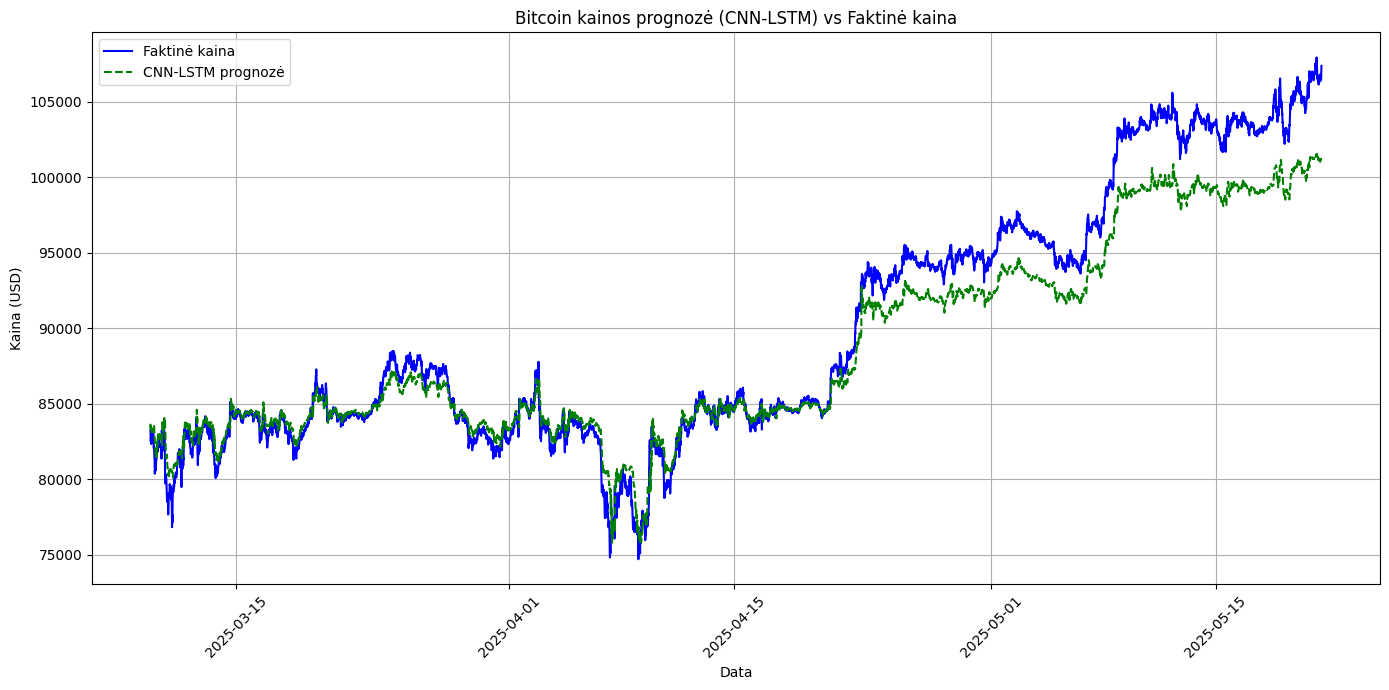

In [11]:
# --- 11. Prognozių vizualizacija ---
# Pasiimame testavimo rinkinių datas
test_dates = df_original['time'].iloc[-len(y_test):].reset_index(drop=True)

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='blue')
plt.plot(test_dates, y_pred_original, label='CNN-LSTM prognozė', color='green', linestyle='--')
plt.title('Bitcoin kainos prognozė (CNN-LSTM) vs Faktinė kaina')
plt.xlabel('Data')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# --- 12. Modelio informacijos išsaugojimas ---
model_info = {
    'model_type': 'CNN-LSTM',
    'input_shape': [sequence_length, len(feature_columns)],
    'sequence_length': sequence_length,
    'target_column': target_column,
    'metrics': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'mape': float(mape)
    }
}

model_info_path = '../../models/cnn_lstm_model_info.json'
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"Modelio informacija išsaugota: {model_info_path}")

Modelio informacija išsaugota: ../../models/cnn_lstm_model_info.json
